# Notebook de développement du modèle

Ce dataset comporte peu de données pour chaque classe (entre 60 et 100). <br>
Ainsi il faudra adapter les méthodes d'apprentissages.

## Data Management

In [73]:
import numpy as np
import pandas as pd
import os
from PIL import Image
import glob
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from keras import  layers, models

from keras.preprocessing.image import ImageDataGenerator 
import cv2 

In [3]:
liste_poissons=['apognon','epinephelus_marginatus','girelle_paon','pempheris_vanicolensis','sparisoma_cretense']
route_image_genere='data/generated/color/'
route_image_couleur='data/color/'

### Renommer les fichiers

In [4]:

'''
for espece in liste_poissons:
    root = r"data/generated/color/{}".format(espece)
    print(root)
    count = 0
    for dirs, subdir, files in os.walk(root):
        for file in files:
            os.rename(root+"/"+file,root+"/{}{}.jpg".format(espece,count))
            count+=1

'''


'\nfor espece in liste_poissons:\n    root = r"data/generated/color/{}".format(espece)\n    print(root)\n    count = 0\n    for dirs, subdir, files in os.walk(root):\n        for file in files:\n            os.rename(root+"/"+file,root+"/{}{}.jpg".format(espece,count))\n            count+=1\n\n'

### Redimmensionner les images

In [5]:

'''
for espece in liste_poissons:
    files = glob.glob('./data/generated/color/{}/*'.format(espece))

    for file in files:
        img = Image.open(file)
        img_resize = img.resize((150, 100))
        root, ext = os.path.splitext(file)
        basename = os.path.basename(root)
        print(basename)
        img_resize.save(os.path.join('./data/generated/color/{}/'.format(espece), basename+'.jpg'))
'''

"\nfor espece in liste_poissons:\n    files = glob.glob('./data/generated/color/{}/*'.format(espece))\n\n    for file in files:\n        img = Image.open(file)\n        img_resize = img.resize((150, 100))\n        root, ext = os.path.splitext(file)\n        basename = os.path.basename(root)\n        print(basename)\n        img_resize.save(os.path.join('./data/generated/color/{}/'.format(espece), basename+'.jpg'))\n"

### Verifier que les dimensions de chaque images soient bien les mêmes

In [6]:

'''
for espece in liste_poissons:
    files = glob.glob('./data/generated/color/{}/*'.format(espece))
    compteur=0
    for f in files:
        im = np.array(Image.open(f))

        if im.dtype!='uint8':
            print("mauvais type"+str(compteur))
            print(im.dtype)
        if im.shape!=(100,150,3):
            print("l'image {} n'a pas les bonnes dimensions!".format(compteur))
            print(im.shape)
        compteur+=1

'''


'\nfor espece in liste_poissons:\n    files = glob.glob(\'./data/generated/color/{}/*\'.format(espece))\n    compteur=0\n    for f in files:\n        im = np.array(Image.open(f))\n\n        if im.dtype!=\'uint8\':\n            print("mauvais type"+str(compteur))\n            print(im.dtype)\n        if im.shape!=(100,150,3):\n            print("l\'image {} n\'a pas les bonnes dimensions!".format(compteur))\n            print(im.shape)\n        compteur+=1\n\n'

### Conversion des images en niveaux de gris

In [7]:
'''
for espece in liste_poissons:
    files = glob.glob('./data/grey/{}/*'.format(espece))
    for file in files:
        img = Image.open(file).convert('L')
        root, ext = os.path.splitext(file)
        basename = os.path.basename(root)
        img.save(os.path.join('./data/grey/{}/'.format(espece), basename+'.jpg'))
'''

"\nfor espece in liste_poissons:\n    files = glob.glob('./data/grey/{}/*'.format(espece))\n    for file in files:\n        img = Image.open(file).convert('L')\n        root, ext = os.path.splitext(file)\n        basename = os.path.basename(root)\n        img.save(os.path.join('./data/grey/{}/'.format(espece), basename+'.jpg'))\n"

### Generation d'image

In [10]:
'''
for root, _, files in os.walk('data/color/apognons'):
    print(root, len(files))
'''

"\nfor root, _, files in os.walk('data/color/apognons'):\n    print(root, len(files))\n"

In [11]:
'''
dataset=ImageDataGenerator(horizontal_flip=True, vertical_flip=True)
length=0

for espece in liste_poissons:
  generator=dataset.flow_from_directory('data/color/{}'.format(espece+'s'),target_size=(150,100),save_to_dir='data/generated/color/{}'.format(espece), save_prefix=espece,save_format='jpg',batch_size=3)
  for root, _, files in os.walk('data/color/{}'.format(espece+'s')):
      length=len(files)

  for i in range(length):
    image = next(generator)[0].astype('uint8')
'''

"\ndataset=ImageDataGenerator(horizontal_flip=True, vertical_flip=True)\nlength=0\n\nfor espece in liste_poissons:\n  generator=dataset.flow_from_directory('data/color/{}'.format(espece+'s'),target_size=(150,100),save_to_dir='data/generated/color/{}'.format(espece), save_prefix=espece,save_format='jpg',batch_size=3)\n  for root, _, files in os.walk('data/color/{}'.format(espece+'s')):\n      length=len(files)\n\n  for i in range(length):\n    image = next(generator)[0].astype('uint8')\n"

### Creation d'une liste d'image au format .npy

In [12]:
'''
training_data = []
for espece in liste_poissons:
    files = glob.glob('./data/grey/{}/*'.format(espece))
    for f in files:
        img=cv2.imread(f)
        training_data.append([img])
np.save(os.path.join('./data/grey','liste_img_grey'),np.array(training_data))
'''


"\ntraining_data = []\nfor espece in liste_poissons:\n    files = glob.glob('./data/grey/{}/*'.format(espece))\n    for f in files:\n        img=cv2.imread(f)\n        training_data.append([img])\nnp.save(os.path.join('./data/grey','liste_img_grey'),np.array(training_data))\n"

### Création d'un array contenant les images ainsi que leur sortie

In [176]:
#Loads image
training_data=list()
y_training_data=list()
test_data=list()
y_test_data=list()
liste_routes=['./data/color/','./data/generated/color/']
k=0
for r in liste_routes:
    k+=1
    classe=0
    for espece in liste_poissons:
        files=None
        if k==1:
            files = glob.glob(r +'{}/{}/*'.format(espece+'s',espece))
        if k==2:
            files = glob.glob(r +'{}/*'.format(espece))
        i=0
        for f in files:
            output=[0,0,0,0,0]
            output[classe]=1
            img=cv2.imread(f)
            #normalisation entre 0 et 1
            
            if len(files)/2<=i:
                #training_data.append([img/255,output])
                training_data.append(img/255)
                y_training_data.append(output)
            else:
                #test_data.append([img/255,output])
                test_data.append(img/255)
                y_test_data.append(output)
            
            i+=1  
        classe+=1
    print(len(training_data))

training_data=np.array(training_data)
y_training_data=np.array(y_training_data)
test_data=np.array(test_data)
y_test_data=np.array(y_test_data)

188
750


In [177]:
print(len(training_data))

750


In [178]:
print(len(test_data))

756


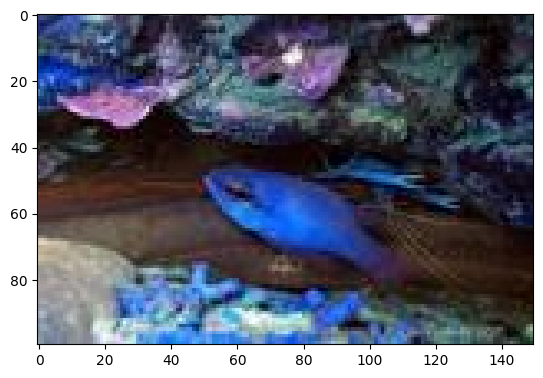

In [179]:

plt.imshow(test_data[1])
plt.show()

In [100]:
print(y_test_data)

[[1 0 0 0 0]
 [1 0 0 0 0]
 [1 0 0 0 0]
 ...
 [0 0 0 0 1]
 [0 0 0 0 1]
 [0 0 0 0 1]]


## Création du modèle

### Modele créer en local

Pour ce modèle il n'y aura pas de données de test, seulement les données de validations à cause du nombre restreint de données

In [210]:
model = models.Sequential()
model.add(layers.Conv2D(16, (3, 3), activation='relu', input_shape=(100, 150, 3)))
model.add(layers.MaxPooling2D())
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D())
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(64,activation='relu'))
model.add(layers.Dense(32,activation='relu'))
model.add(layers.Dense(16,activation='relu'))
model.add(layers.Dense(5,activation='softmax'))

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999)

model.compile(optimizer=optimizer,
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

In [194]:
#model.summary()

In [211]:
epochs=10
history = model.fit(
  training_data,
  y_training_data,
  validation_data=(test_data,y_test_data),
  epochs=epochs,
  batch_size=5
)

Epoch 1/10
 66/150 [============>.................] - ETA: 19s - loss: 1.5866 - accuracy: 0.2606

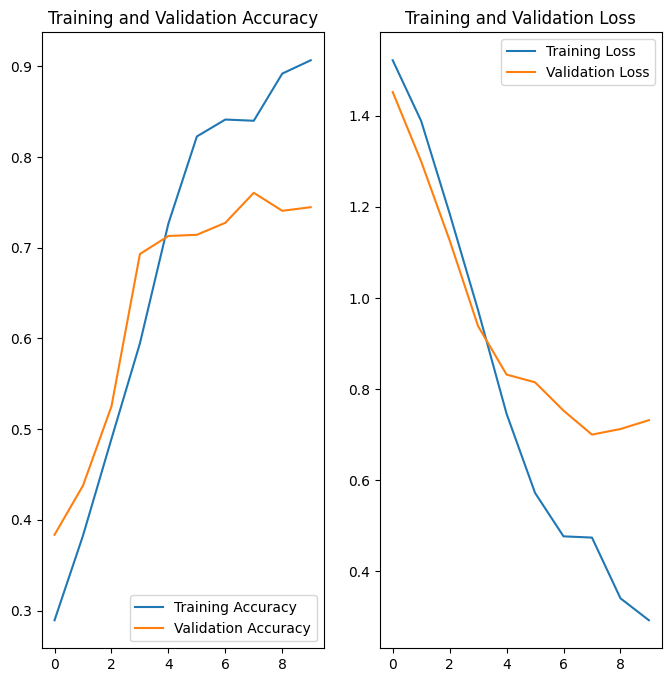

In [208]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()